In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import algorithms
from linear_regression import LinearRegression
from gurobipy import GRB
import scipy.linalg
import itertools

## Load and Plot Data.

In [70]:
# read in the genome data.
genome_data = pd.read_csv('data/genomics.csv')
genome_data.head()

,vip,gad1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


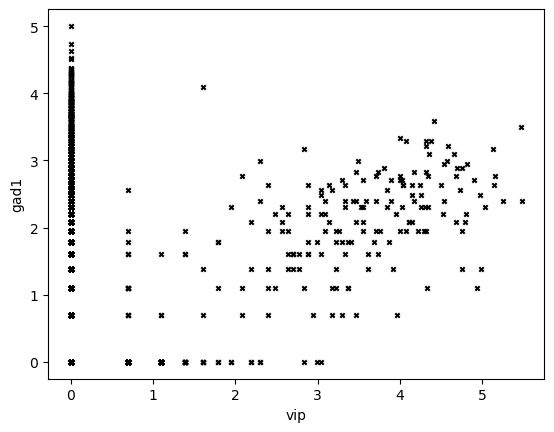

In [71]:
# create a scatter plot of d.st vs. h.t
plt.scatter(genome_data['vip'], genome_data['gad1'], s=10, c='black', marker='x')
plt.xlabel('vip')
plt.ylabel('gad1')
plt.show()

In [72]:
# find the number of non-zero entries in the vip column
non_zero_vip = genome_data['vip'].astype(bool).sum()
print(f"Number of non-zero entries in vip: {non_zero_vip}")
# find the number total number of entries in the vip column
total_entries_vip = genome_data['vip'].count()
print(f"Total number of entries in vip: {total_entries_vip}")
# print the proportion of non-zero entries in the vip column
proportion_non_zero_vip = non_zero_vip / total_entries_vip
print(f"Proportion of non-zero entries in vip: {proportion_non_zero_vip:.2%}")
# find the number of non-zero entries in the gad1 column
non_zero_gad1 = genome_data['gad1'].astype(bool).sum()
print(f"Number of non-zero entries in gad1: {non_zero_gad1}")
# find the number total number of entries in the gad1 column
total_entries_gad1 = genome_data['gad1'].count()
print(f"Total number of entries in gad1: {total_entries_gad1}")
# print the proportion of non-zero entries in the gad1 column
proportion_non_zero_gad1 = non_zero_gad1 / total_entries_gad1
print(f"Proportion of non-zero entries in gad1: {proportion_non_zero_gad1:.2%}")


Number of non-zero entries in vip: 330
Total number of entries in vip: 65539
Proportion of non-zero entries in vip: 0.50%
Number of non-zero entries in gad1: 1712
Total number of entries in gad1: 65539
Proportion of non-zero entries in gad1: 2.61%


In [73]:
# fit a linear regression.
x = genome_data['vip'].to_numpy()
y = genome_data['gad1'].to_numpy()
# reshape x to be a 2D array
x = x.reshape(-1, 1)
# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr

In [132]:
# Compute condition numbers
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

Condition number of full dataset: 5.242052847992159


In [77]:
# fit the model
lr = LinearRegression(x=x.T, y=y)
lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
) 

Estimated beta1 with full dataset: 0.535506124899345


## Data-Dropping Approximations.

### Netapprox.

In [78]:
Xnet = np.zeros((x.shape[0],x.shape[1]))
Xnet[:,0] =  x[:,1]
Xnet[:,1] =  x[:,0]

In [79]:
Xnet

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [81]:
trials = 1000 # MR23: "trials should be chosen as large as possible subject to computational constraints."
n_sumwstar, wstar = algorithms.net_algorithm(Xnet,y,1000)
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indices of the MIS.
alphaN = 656
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 183.04314478806918


array([36145, 19668, 37151, 21422, 36531, 53440,  7344, 46859, 30047,
        3983, 32085, 38153,  2956,   229,  8047, 19346, 35129, 19691,
       39149, 32583, 35744, 35138,  5534, 22728, 11917, 41262, 41478,
       48670, 31123, 47202, 64025, 53140, 49255, 35390, 32688,   682,
       37090, 50331, 24456, 19404,  8413, 48453, 10988, 23135, 27267,
       36821, 17660, 61220, 48169, 32988,  1250,  4023,   176, 19653,
       22368, 57112, 61224, 32941, 30918,  3948, 11587, 24281, 48822,
       22198, 11532, 36162, 35682, 35213, 40202, 21842,  3379, 14631,
       56970, 11543, 49959, 64703, 52933, 17810, 45801, 37304, 20232,
       56951,  7460, 29967,   368, 36598, 19291, 16141,   873, 35149,
       26447,  3321, 51012, 35308,   434, 40289, 30325, 62090, 62735,
       21374,  8679,  7377, 35170, 18777,  1426, 42304, 46364,   884,
       30450, 39648,  9122, 19824, 63681, 27008, 27187, 30461, 10239,
       40854, 23116, 32270,  7733, 50297, 26704, 53177, 14412, 37504,
       63446, 55155,

In [82]:
len(mis_inds)

656

In [83]:
#### Refit after Removing Flagged Points.
new_x= np.delete(x, mis_inds, axis=0)
new_y= np.delete(y, mis_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(64883, 2)
(64883,)


In [84]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by NetApprox: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.535506124899345
Estimated beta1 after removing subset specified by NetApprox: -0.0022290556400391794


In [31]:
lr.beta[0]

0.04324896539646269

In [17]:
# retrieve all x values that that are in mis_inds.
mis_df = genome_data.iloc[mis_inds]
# retrieve the x values.
mis_x = mis_df['vip'].to_numpy()
# retrieve the y values.
mis_y = mis_df['gad1'].to_numpy()

# retrieve the x values that are not in mis_inds.
not_mis_df = genome_data.drop(mis_inds)
# retrieve the x values.
not_mis_x = not_mis_df['vip'].to_numpy()
# retrieve the y values.
not_mis_y = not_mis_df['gad1'].to_numpy()

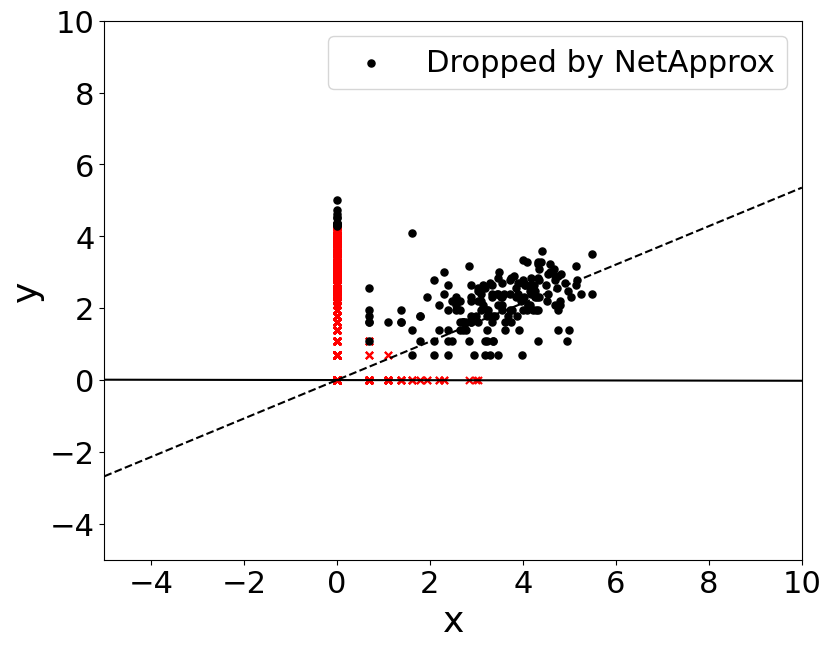

In [ ]:
### create scatter plot.
plt.figure(figsize=(9, 7))

plt.scatter(not_mis_x, not_mis_y, marker='x', color='red', s=26)
plt.scatter(mis_x, mis_y, marker='o', color='black', label='Dropped by NetApprox', s=26)

x_values = np.linspace(-5, 10, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + lr.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.ylim(-5, 10)
plt.xlim(-5, 10)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.savefig('genomics_dropped_by_netapprox.pdf')
plt.show()

### FH-Gurobi (warm-start)

In [ ]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x, y, intercept=True, time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

In [ ]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(Xnet,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

In [ ]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove, len(indices_to_remove)

In [112]:
#### Refit after Removing Flagged Points.
mis_inds = indices_to_remove
new_x= np.delete(x, mis_inds, axis=0)
new_y= np.delete(y, mis_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(65367, 2)
(65367,)


In [113]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by FH-Gurobi (warm-start): {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.535506124899345
Estimated beta1 after removing subset specified by FH-Gurobi (warm-start): 0.001504687975359893


### FH-Gurobi

In [89]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 65542 columns and 1 nonzeros
Model fingerprint: 0xccd93744
Model has 3 quadratic constraints
Variable types: 3 continuous, 65539 integer (65539 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-01, 3e+01]
  QLMatrix range   [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.26s
Presolved: 262818 rows, 459766 columns, 791332 nonzeros
Presolved model has 262816 SOS constraint(s)
Variable types: 262819 continuous, 196947 integer (196947 binary)

Ro

In [90]:
weights_array = np.array([w.X for w in weights])

In [91]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([    8,    13,    35, ..., 64831, 65056, 65152])

In [92]:
len(indices_to_remove)

1712

In [93]:
Gurobi_inds=indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(63827, 2)
(63827,)


In [94]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by gurobi: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 0.535506124899345
Estimated beta1 after removing subset specified by gurobi: 0.0


### Additive Algorithms

In [114]:
import postprocessing
genomics_df = postprocessing.compute_scores(x, y, lr, True)

In [115]:
genomics_df.head()

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,0.0,-0.043249,0.000015,-2.047092e-07,-2.047123e-07,50331,50331,-0.002169,-0.002187
1,1.0,0.0,-0.043249,0.000015,-2.047092e-07,-2.047123e-07,19346,19346,-0.002136,-0.002139
2,1.0,0.0,-0.043249,0.000015,-2.047092e-07,-2.047123e-07,41644,41644,-0.001915,-0.001927
3,1.0,0.0,-0.043249,0.000015,-2.047092e-07,-2.047123e-07,7460,7460,-0.001913,-0.001920
4,1.0,0.0,-0.043249,0.000015,-2.047092e-07,-2.047123e-07,24525,24525,-0.001822,-0.001835


In [133]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(genomics_df["sorted_IF_scores"][:656]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size 172 is {round(lr.beta[1] + sum(genomics_df["sorted_1Exact_scores"][:656]), 4)}.')

The AMIP approximation of the refit is 0.4514.
The Add-1Exact for the change induced by dropping the worst-case subset of size 172 is 0.451.


In [134]:
amip_inds = genomics_df['sorted_IF_indices'][:656].values
oneexact_inds = genomics_df['sorted_1Exact_indices'][:656].values

In [135]:
#### Refit after Removing Flagged Points.
new_amip_x= np.delete(x, amip_inds, axis=0)
new_amip_y= np.delete(y, amip_inds, axis=0)
print(new_amip_x.shape)
print(new_amip_y.shape)

new_1exact_x= np.delete(x, oneexact_inds, axis=0)
new_1exact_y= np.delete(y, oneexact_inds, axis=0)
print(new_1exact_x.shape)
print(new_1exact_y.shape)

(64883, 2)
(64883,)
(64883, 2)
(64883,)


In [136]:
# Refit after removing the points specified by AMIP (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_AMIP = LinearRegression(x=new_amip_x.T, y=new_amip_y)
modified_lr_AMIP.fit()
print(
    f"Estimated beta1 after removing subset selected using AMIP: {modified_lr_AMIP.beta[1]}"
)
modified_lr_1Exact = LinearRegression(x=new_1exact_x.T, y=new_1exact_y)
modified_lr_1Exact.fit()
print(
    f"Estimated beta1 after removing subset selected using 1Exact: {modified_lr_1Exact.beta[1]}"
)

Estimated beta1 with full dataset: 0.535506124899345
Estimated beta1 after removing subset selected using AMIP: 0.3550494805831138
Estimated beta1 after removing subset selected using 1Exact: 0.3550494805831138


### Greedy Algorithms

In [124]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = postprocessing.create_orig_df(orig_x, orig_y, lr, True)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

inds [50331 19346 41644  7460 24525  3639 24456 46364 27169 35000]
newton_inds [50331 19346 41644  7460 24525  3639 24456 46364 27169 35000]


In [125]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = algorithms.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, True, method='1Exact')

iteration 0
index to remove (original): 50331
fitted beta1: 0.5333194020391456
iteration 1
index to remove (original): 19346
fitted beta1: 0.5311605962951701
iteration 2
index to remove (original): 41644
fitted beta1: 0.5291853562310866
iteration 3
index to remove (original): 7460
fitted beta1: 0.5272126622335825
iteration 4
index to remove (original): 24525
fitted beta1: 0.525282225042158
iteration 5
index to remove (original): 3639
fitted beta1: 0.5234422179747107
iteration 6
index to remove (original): 24456
fitted beta1: 0.5216084197567552
iteration 7
index to remove (original): 46364
fitted beta1: 0.5198482308546463
iteration 8
index to remove (original): 35000
fitted beta1: 0.5180751217198887
iteration 9
index to remove (original): 27169
fitted beta1: 0.5163071077367091
iteration 10
index to remove (original): 37304
fitted beta1: 0.5146479555656105
iteration 11
index to remove (original): 24281
fitted beta1: 0.5130635232511205
iteration 12
index to remove (original): 32880
fitted

In [126]:
beta_estimates_greedy[172]

-0.0027255263567384767

In [127]:
greedy_inds = dropped_order[:173]

In [128]:
#### Refit after Removing Flagged Points.
new_x= np.delete(orig_x, greedy_inds, axis=0)
new_y= np.delete(orig_y, greedy_inds, axis=0)
orig_x.shape, new_x.shape

((65539, 2), (65366, 2))

In [129]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=orig_x.T, y=orig_y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.535506124899345
Estimated beta1 after removing subset: -0.0027255263567384767


In [130]:
# retrieve all x values that that are in mis_inds.
mis_df = genome_data.iloc[greedy_inds]
# retrieve the x values.
mis_x = mis_df['vip'].to_numpy()
# retrieve the y values.
mis_y = mis_df['gad1'].to_numpy()

# retrieve the x values that are not in mis_inds.
not_mis_df = genome_data.drop(greedy_inds)
# retrieve the x values.
not_mis_x = not_mis_df['vip'].to_numpy()
# retrieve the y values.
not_mis_y = not_mis_df['gad1'].to_numpy()

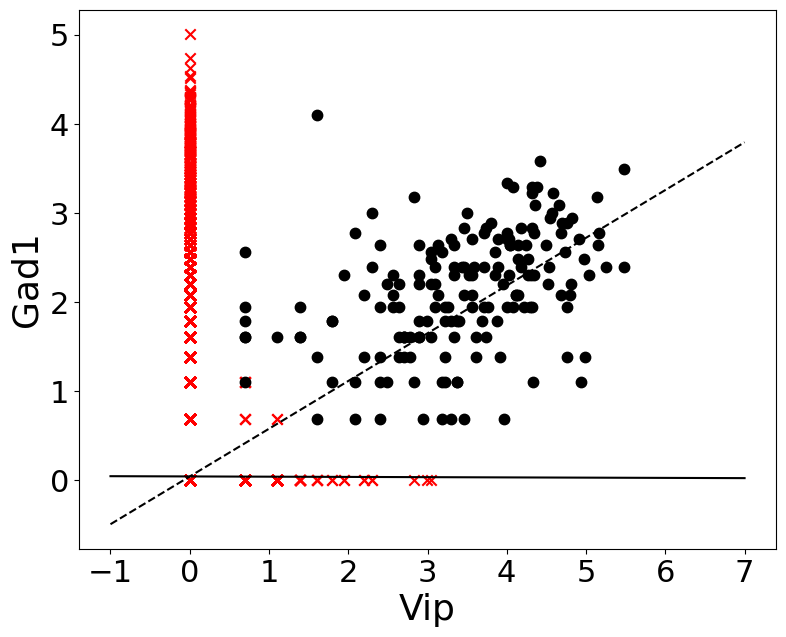

In [ ]:
### create scatter plot.
plt.figure(figsize=(9, 7))

plt.scatter(not_mis_x, not_mis_y, marker='x', color='red', label='Kept by Greedy', s=56)
plt.scatter(mis_x, mis_y, marker='o', color='black', label='Dropped by Greedy', s=56)

x_values = np.linspace(-1, 7, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('Vip', fontsize=26)
plt.ylabel('Gad1', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
# plt.legend(fontsize=22)
# plt.savefig('genomics_scatter.pdf')
plt.show()